-------------------0805+2818a-------------------
Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726' '[OII]3729' '[SII]6716'
 '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:        -4       229     0.083     0.090
 comp. 1:       -97       255
 comp. 2:      -115       316
chi2/DOF: 0.00499
method = capfit ; Jac calls: 13 ; Func calls: 252 ; Status: 2
Nonzero Templates:  134  /  161
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta      2.419       4.9     -97   255
Comp: 1        Hgamma      5.742       5.1     -97   255
Comp: 1         Hbeta      12.07       6.2     -97   255
Comp: 1        Halpha       44.1        10     -97   255
Comp: 2     [OII]3726      5.282        19    -115   316
Comp: 2     [OII]3729      23.59        20    -115 

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in divide


Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726' '[OII]3729' '[SII]6716'
 '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:       -68       162     0.033     0.061
 comp. 1:      -112       179
 comp. 2:      -113       231
chi2/DOF: 0.001477
method = capfit ; Jac calls: 6 ; Func calls: 116 ; Status: 2
Nonzero Templates:  152  /  161
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta     0.2848       3.1    -112   179
Comp: 1        Hgamma     0.7311       2.9    -112   179
Comp: 1         Hbeta      1.882         3    -112   179
Comp: 1        Halpha      5.466       2.9    -112   179
Comp: 2     [OII]3726          0       7.9    -113   231
Comp: 2     [OII]3729      5.503       8.4    -113   231
Comp: 2     [SII]6716      1.629       2.6 

-------------------1330-0036b-------------------
Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726' '[OII]3729' '[SII]6716'
 '[SII]6731' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
Best Fit:       Vel     sigma        h3        h4
 comp. 0:       263       141    -0.030     0.147
 comp. 1:       291       102
 comp. 2:       262       114
chi2/DOF: 0.002318
method = capfit ; Jac calls: 11 ; Func calls: 213 ; Status: 2
Nonzero Templates:  148  /  161
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta     0.8556       4.6     291   102
Comp: 1        Hgamma     0.9797       4.5     291   102
Comp: 1         Hbeta      2.319       3.4     291   102
Comp: 1        Halpha      11.62       3.7     291   102
Comp: 2     [OII]3726       7.33       9.8     262   114
Comp: 2     [OII]3729          0       7.9     262

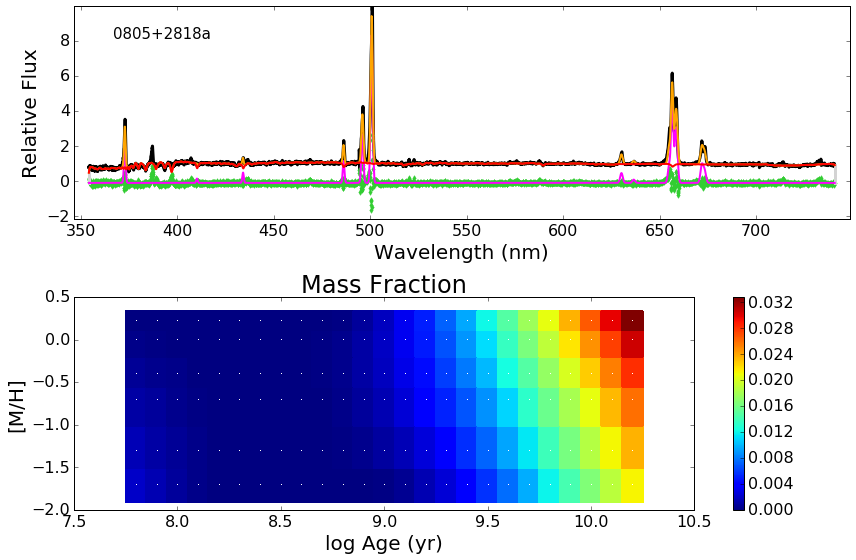

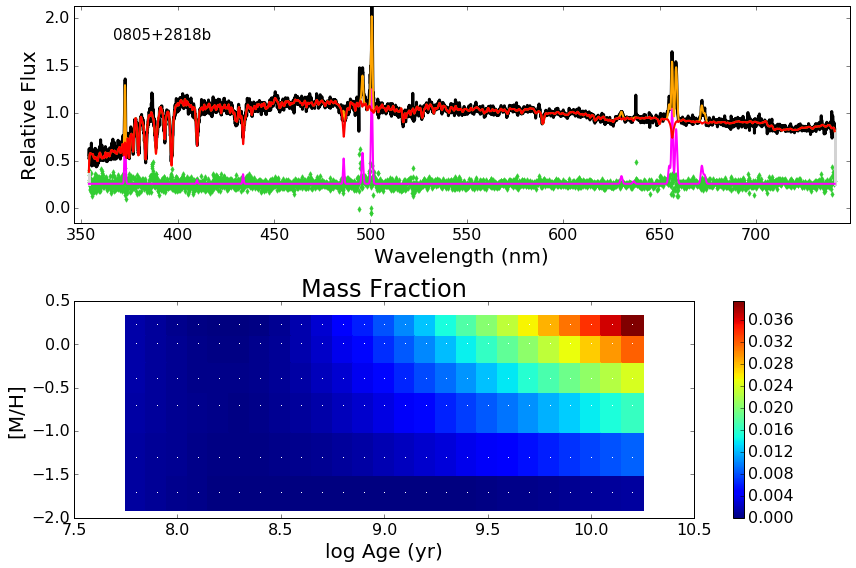

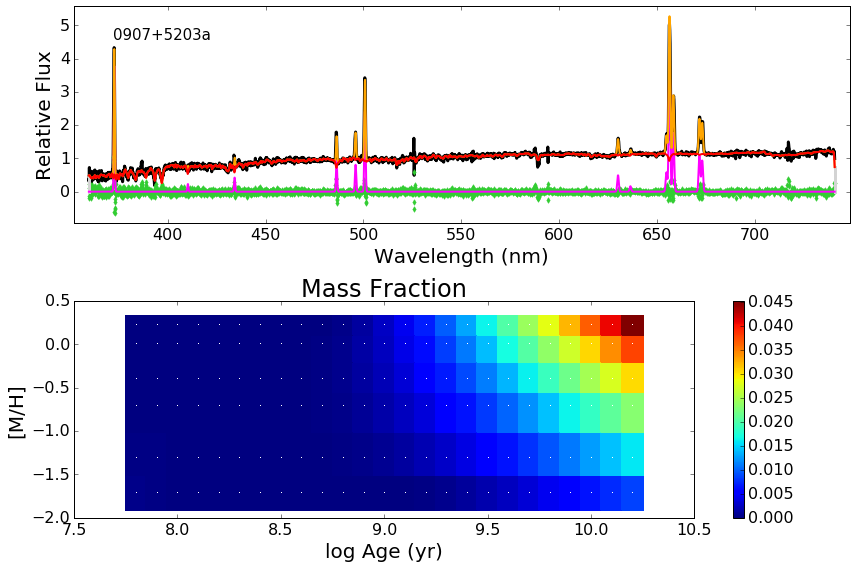

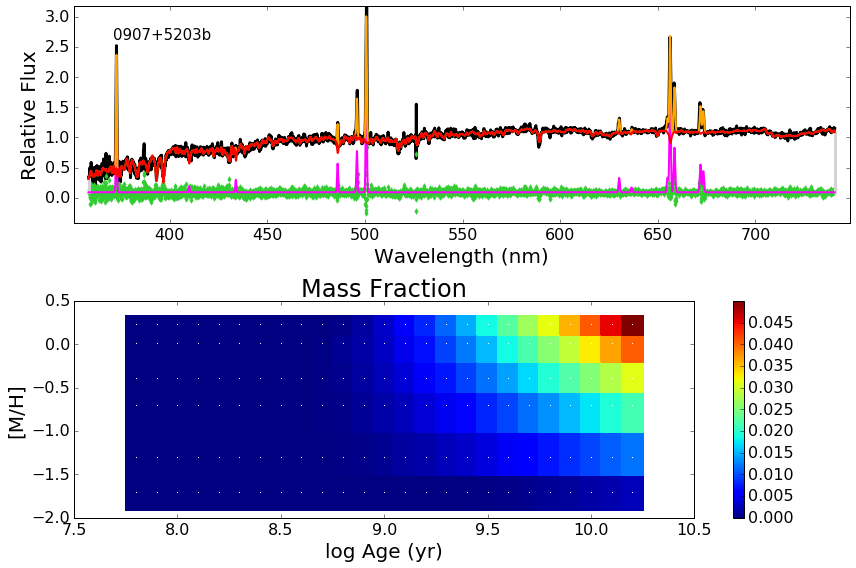

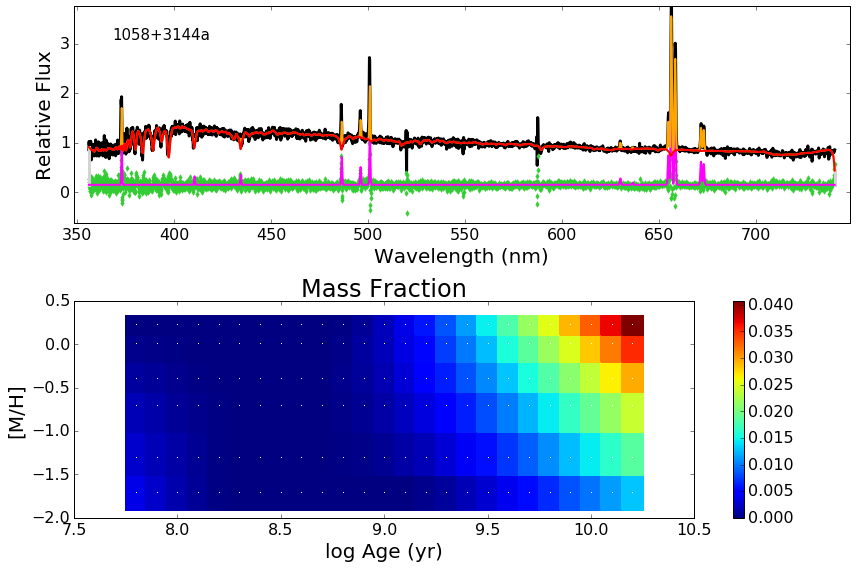

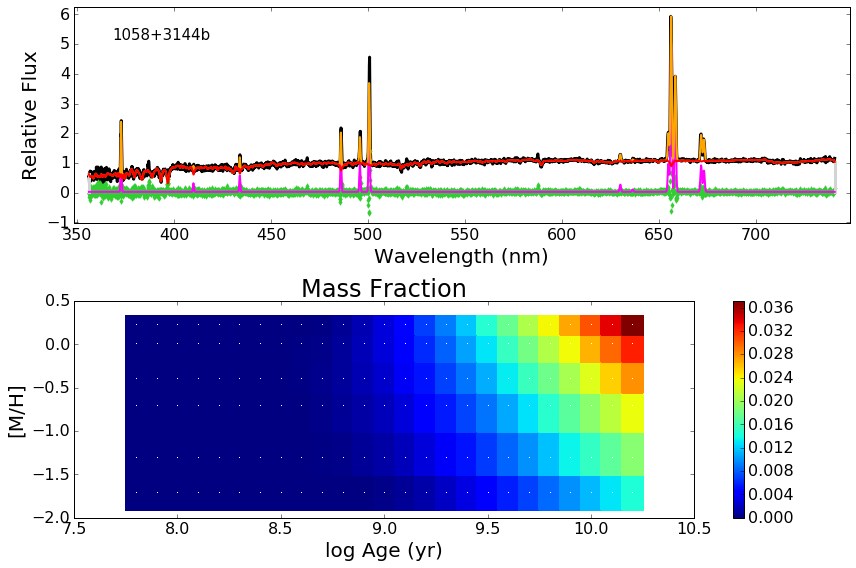

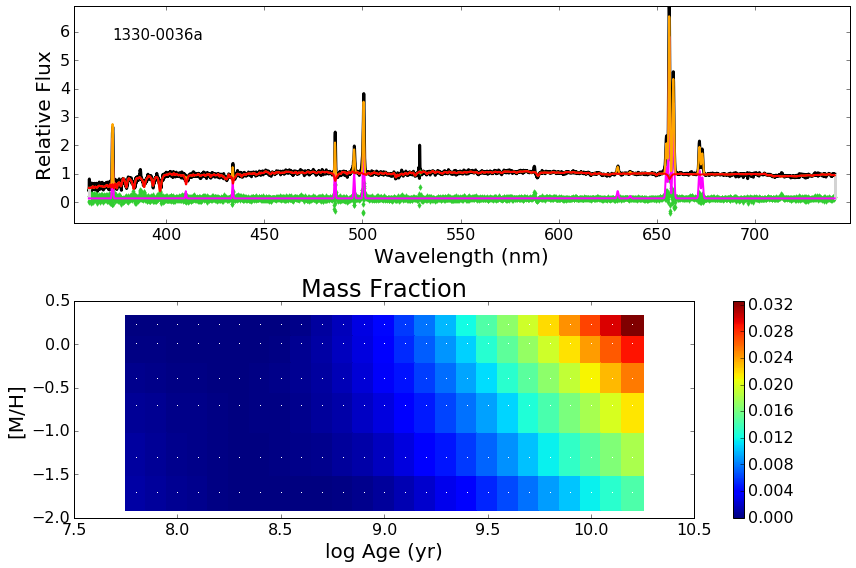

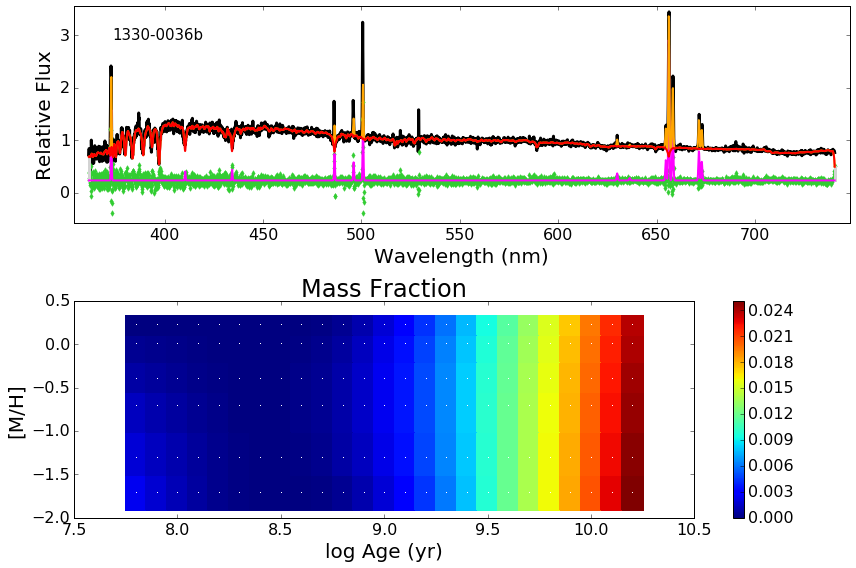

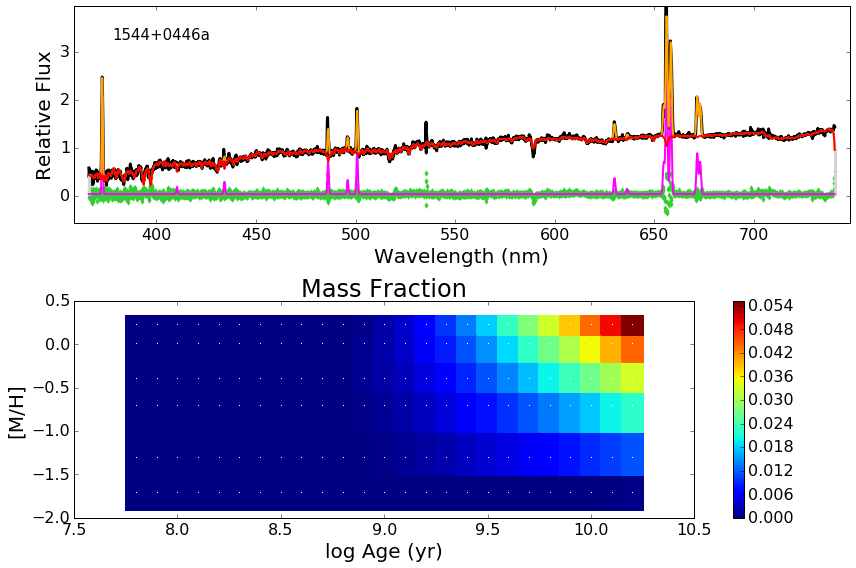

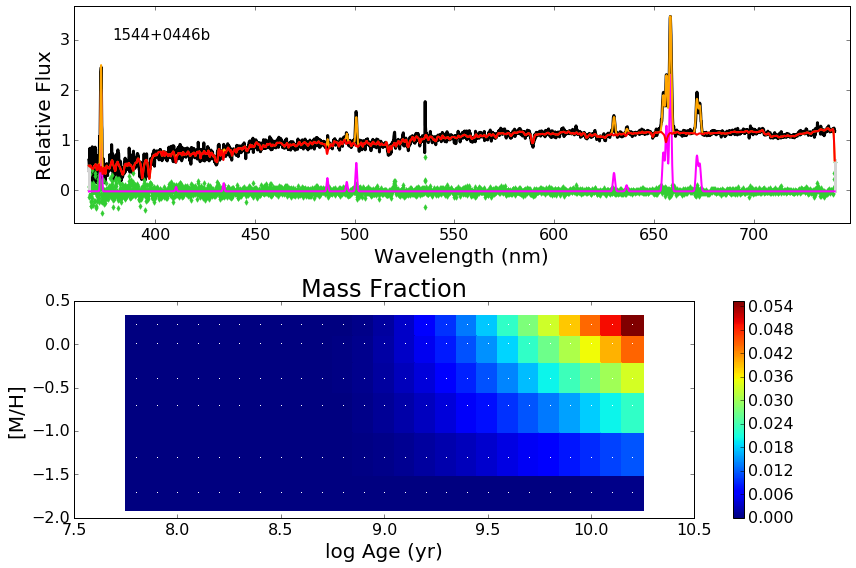

In [87]:
%matplotlib inline
# %load ppxf_example_population_gas_sdss.py
#!/usr/bin/env python
##############################################################################
#
# Usage example for the procedure PPXF, which implements the
# Penalized Pixel-Fitting (pPXF) method originally described in
# Cappellari M., & Emsellem E., 2004, PASP, 116, 138
#     http://adsabs.harvard.edu/abs/2004PASP..116..138C
# and upgraded in Cappellari M., 2017, MNRAS, 466, 798
#     http://adsabs.harvard.edu/abs/2017MNRAS.466..798C
#
# This example shows how to study stellar population and include gas emission
# lines as templates instead of masking them using the GOODPIXELS keyword.
#


##############################################################################

from time import clock
from os import path
import glob, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

##############################################################################

def ppxf_example_population_gas_sdss(tie_balmer, limit_doublets):

    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    # Read SDSS DR8 galaxy spectrum taken from here http://www.sdss3.org/dr8/
    # The spectrum is *already* log rebinned by the SDSS DR8
    # pipeline and log_rebin should not be used in this case.
    #
    #file = ppxf_dir + '/spectra/NGC3522_SDSS_DR8.fits'


    for i in zip(glob.glob('/Users/legolason/study/otherwork/meicun/data/*.fits'),\
                    range(10),['0805+2818a','0805+2818b','0907+5203a','0907+5203b',\
                        '1058+3144a','1058+3144b','1330-0036a','1330-0036b','1544+0446a','1544+0446b']):
        print '-------------------'+i[2]+'-------------------'
        hdu = fits.open(i[0])
        t = hdu[1].data
        
        wave1 = 10**t['loglam']/(1.+ float(hdu[2].data['z']))
        flux1 = t['flux']
        err1 = 1./np.sqrt(t['ivar'])
        #err[np.where(err == np.inf,True,False)] = 1.
        z = 0.

        # Only use the wavelength range in common between galaxy and stellar library.
        #
        mask = np.where( (wave1 > 3541.) & (wave1 < 7409.) & (err1 <100.), True, False)
        
        flux = flux1[mask]
        galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
        wave = wave1[mask]
        err = err1[mask]
        
        

        # The SDSS wavelengths are in vacuum, while the MILES ones are in air.
        # For a rigorous treatment, the SDSS vacuum wavelengths should be
        # converted into air wavelengths and the spectra should be resampled.
        # To avoid resampling, given that the wavelength dependence of the
        # correction is very weak, I approximate it with a constant factor.
        #
        wave *= np.median(util.vac_to_air(wave)/wave)


        # The noise level is chosen to give Chi^2/DOF=1 without regularization (REGUL=0).
        # A constant noise is not a bad approximation in the fitted wavelength
        # range and reduces the noise in the fit.
        #
        #noise = np.full_like(galaxy, 0.01635)  # Assume constant noise per pixel here
        noise = err

        # The velocity step was already chosen by the SDSS pipeline
        # and we convert it below to km/s
        #
        c = 299792.458  # speed of light in km/s
        velscale = c*np.log(wave[1]/wave[0])  # eq.(8) of Cappellari (2017)
        FWHM_gal = 2.76  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

        #------------------- Setup templates -----------------------

        pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'
        miles = lib.miles(pathname, velscale, FWHM_gal)


        # The stellar templates are reshaped below into a 2-dim array with each
        # spectrum as a column, however we save the original array dimensions,
        # which are needed to specify the regularization dimensions
        #
        reg_dim = miles.templates.shape[1:]
        stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)

        # See the pPXF documentation for the keyword REGUL,
        regul_err = 0.013  # Desired regularization error

        # Construct a set of Gaussian emission line templates.
        # Estimate the wavelength fitted range in the rest frame.
        #
        lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1 + z)
        gas_templates, gas_names, line_wave = util.emission_lines(
            miles.log_lam_temp, lam_range_gal, FWHM_gal,
            tie_balmer=tie_balmer, limit_doublets=limit_doublets)

        # Combines the stellar and gaseous templates into a single array.
        # During the PPXF fit they will be assigned a different kinematic
        # COMPONENT value
        #

        templates = np.column_stack([stars_templates, gas_templates])

        #-----------------------------------------------------------

        # The galaxy and the template spectra do not have the same starting wavelength.
        # For this reason an extra velocity shift DV has to be applied to the template
        # to fit the galaxy spectrum. We remove this artificial shift by using the
        # keyword VSYST in the call to PPXF below, so that all velocities are
        # measured with respect to DV. This assume the redshift is negligible.
        # In the case of a high-redshift galaxy one should de-redshift its
        # wavelength to the rest frame before using the line below as described
        # in PPXF_EXAMPLE_KINEMATICS_SAURON and Sec.2.4 of Cappellari (2017)
        #
        c = 299792.458
        dv = c*(miles.log_lam_temp[0] - np.log(wave[0]))  # eq.(8) of Cappellari (2017)
        vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
        start = [vel, 180.]  # (km/s), starting guess for [V, sigma]

        n_temps = stars_templates.shape[1]
        n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
        n_balmer = len(gas_names) - n_forbidden

        # Assign component=0 to the stellar templates, component=1 to the Balmer
        # gas emission lines templates and component=2 to the forbidden lines.
        component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
        gas_component = np.array(component) > 0  # gas_component=True for gas templates

        # Fit (V, sig, h3, h4) moments=4 for the stars
        # and (V, sig) moments=2 for the two gas kinematic components
        moments = [4, 2, 2]

        # Adopt the same starting value for the stars and the two gas components
        start = [start, start, start]

        # If the Balmer lines are tied one should allow for gas reddeining.
        # The gas_reddening can be different from the stellar one, if both are fitted.
        gas_reddening = 0 if tie_balmer else None

        # Here the actual fit starts.
        #
        # IMPORTANT: Ideally one would like not to use any polynomial in the fit
        # as the continuum shape contains important information on the population.
        # Unfortunately this is often not feasible, due to small calibration
        # uncertainties in the spectral shape. To avoid affecting the line strength of
        # the spectral features, we exclude additive polynomials (DEGREE=-1) and only use
        # multiplicative ones (MDEGREE=10). This is only recommended for population, not
        # for kinematic extraction, where additive polynomials are always recommended.
        #
        t = clock()
        pp = ppxf(templates, galaxy, noise, velscale, start,
                  plot=False, moments=moments, degree=-1, mdegree=10, vsyst=dv,
                  lam=wave, clean=False, regul=1./regul_err, reg_dim=reg_dim,
                  component=component, gas_component=gas_component,
                  gas_names=gas_names, gas_reddening=gas_reddening)

        # When the two Delta Chi^2 below are the same, the solution
        # is the smoothest consistent with the observed spectrum.
        #
        print('Desired Delta Chi^2: %.4g' % np.sqrt(2*galaxy.size))
        print('Current Delta Chi^2: %.4g' % ((pp.chi2 - 1)*galaxy.size))
        print('Elapsed time in PPXF: %.2f s' % (clock() - t))

        weights = pp.weights[~gas_component]  # Exclude weights of the gas templates
        weights = weights.reshape(reg_dim)/weights.sum()  # Normalized

        miles.mean_age_metal(weights)
        miles.mass_to_light(weights, band="r")

        # Plot fit results for stars and gas.
        #plt.clf()
        plt.figure(figsize=(12,8))
        plt.style.use('my')
        ax1=plt.subplot(211)
        pp.plot()
        plt.text(0.05, 0.85,i[2], transform=ax1.transAxes,fontsize=15)

        # Plot stellar population mass fraction distribution
        plt.subplot(212)
        miles.plot(weights)
        plt.tight_layout()
        plt.savefig('/Users/legolason/study/otherwork/meicun/fig/'+i[2]+'.eps')

##############################################################################

if __name__ == '__main__':

    #print("\n===============================================\n" +
    #         " Fit with free Balmer lines and [SII] doublet: \n" +
    #         "===============================================\n")

    ppxf_example_population_gas_sdss(tie_balmer=False, limit_doublets=False)

    #print("\n=======================================================\n" +
    #         " Fit with tied Balmer lines and limited [SII] doublet: \n" +
    #         "=======================================================\n")

    # Note tha the inclusion of a few extra faint Balmer lines is sufficient to
    # decrease the chi2 of the fit, even though the Balmer decrement is fixed.
    # In this case, the best-fitting gas reddening is at the E(B-V)=0 boundary.
    #ppxf_example_population_gas_sdss(tie_balmer=True, limit_doublets=True)
